# Algorytmy Macierzowe zadanie 4: Dodawanie i mnożenie macierzy hierarchicznych
## Autorzy:

*   Kapcer Garus
*   Jakub Frączek


# Pseudokod
## Funkcja MatrixVectorMult
```plaintext
Funkcja MatrixVectorMult(węzeł, wektor):
    Jeśli węzeł nie ma liści:
        Jeśli węzeł nie ma U ani V:
            Zwróć wektor zerowy o takim samym rozmiarze jak wektor wejściowy
        W przeciwnym razie:
            Zwróć iloczyn macierzy węzła.U i (węzeł.V pomnożonego przez wektor)

    Podziel wektor na dwie części (wektor1, wektor2)
    Rekursywnie wywołaj MatrixVectorMult na każdej części liści węzła:
        res1 = MatrixVectorMult(węzeł.liście[0], wektor1)
        res2 = MatrixVectorMult(węzeł.liście[1], wektor2)
        res3 = MatrixVectorMult(węzeł.liście[2], wektor1)
        res4 = MatrixVectorMult(węzeł.liście[3], wektor2)

    Zwróć pionowy stos (res1 + res2) i (res3 + res4)

```
## Funkcja MatrixMatrixAdd
```plaintext
Funkcja MatrixMatrixAdd(A, B, ranga, epsilon):
    Funkcja PodzielWęzeł(węzeł, mid_U, mid_V, U1, U2, V1, V2):
        Zwróć cztery nowe węzły, dzieląc macierz A lub B na części według mid_U i mid_V oraz odpowiednich części U, V

    Jeśli A nie ma liści i B nie ma liści:
        Jeśli A i B nie mają U ani V:
            Zwróć nowy węzeł o rozmiarze takim jak A, bez U i V

        W przeciwnym razie:
            Połącz A.U i B.U poziomo (jeśli obecne), a A.V i B.V pionowo (jeśli obecne)
            Stwórz drzewo dla wynikowego iloczynu i zwróć je

    Jeśli tylko A nie ma liści:
        Oblicz mid_U i mid_V dla liści B
        Podziel A na części na podstawie mid_U i mid_V
        Rekursywnie wywołaj PodzielWęzeł na A i B oraz obsłuż przypadki, gdzie U lub V są nieobecne

    Jeśli tylko B nie ma liści:
        Oblicz mid_U i mid_V dla liści A
        Podziel B na części na podstawie mid_U i mid_V
        Rekursywnie wywołaj PodzielWęzeł na A i B oraz obsłuż przypadki, gdzie U lub V są nieobecne

    Jeśli zarówno A, jak i B mają liście:
        Podziel A i B na części i rekursywnie wywołaj MatrixMatrixAdd dla odpowiadających bloków

    Zwróć nowy węzeł z wynikami łączenia czterech submacierzy

```
## Funkcja MatrixMatrixMult
```plaintext
Funkcja MatrixMatrixMult(v, w, ranga, epsilon):
    Funkcja PodzielMacierze(A, B, wymiary, ranga):
        Podziel A i B na górną/dolną i lewą/prawą część, zwróć cztery sub-macierze jako węzły

    Jeśli v nie ma liści i w nie ma liści:
        Jeśli v lub w nie mają U ani V:
            Zwróć nowy węzeł bez U i V

        W przeciwnym razie, oblicz iloczyn macierzy używając wzoru v.U @ (v.V @ w.U) @ w.V
        Zwróć wynik jako węzeł drzewa

    Jeśli tylko v nie ma liści:
        Jeśli w nie ma U ani V:
            Zwróć nowy węzeł bez U i V

        Podziel v na części przy użyciu funkcji PodzielMacierze i przypisz części w z jego liści

    Jeśli tylko w nie ma liści:
        Jeśli v nie ma U ani V:
            Zwróć nowy węzeł bez U i V

        Podziel w na części przy użyciu funkcji PodzielMacierze i przypisz części v z jego liści

    Jeśli zarówno v, jak i w mają liście:
        Podziel v i w na części i rekursywnie wywołaj MatrixMatrixMult dla każdego bloku

    Oblicz cztery wyniki sub-macierzy używając MatrixMatrixAdd dla połączonych bloków z v i w
    Zwróć nowy węzeł z połączonym wynikiem


```

# Funkcje zaimplementowane na poprzednim laboratorium

In [1]:
import time

import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy.sparse.linalg import svds


In [2]:
class Node:
    def __init__(self, rank, size, D=None, U=None, V=None, leaves=None):
        self.rank = rank
        self.size = size
        self.D = D if D is not None else []
        self.U = U
        self.V = V
        self.leaves = leaves



def CreateTree(matrix, t_min, t_max, s_min, s_max, r, eps):
    n_rows, n_cols = t_max - t_min, s_max - s_min

    matrix_slice = matrix[t_min:t_max, s_min:s_max]

    if min(n_rows, n_cols) < 2:
        return Node(1, (t_min, t_max, s_min, s_max), [1], matrix_slice, np.identity(s_max - s_min), None)

    if r > min(n_rows, n_cols) - 1:
        r = min(n_rows, n_cols) - 1
        U, D, V = svds(matrix_slice, r)
        return CompressMatrix(matrix, t_min, t_max, s_min, s_max, U, D, V, r, eps)

    U, D, V = svds(matrix_slice, r)

    if D[0] < eps:
        v = CompressMatrix(matrix, t_min, t_max, s_min, s_max, U, D, V, r, eps)
    else:
        v = Node(r, (t_min, t_max, s_min, s_max), None, None, None, [])
        t_mean = (t_min + t_max) // 2
        s_mean = (s_min + s_max) // 2
        v.leaves.append(CreateTree(matrix, t_min, t_mean, s_min, s_mean, r, eps))
        v.leaves.append(CreateTree(matrix, t_min, t_mean, s_mean, s_max, r, eps))
        v.leaves.append(CreateTree(matrix, t_mean, t_max, s_min, s_mean, r, eps))
        v.leaves.append(CreateTree(matrix, t_mean, t_max, s_mean, s_max, r, eps))

    return v

def CompressMatrix(matrix, t_min, t_max, s_min, s_max, U, D, V, r, delta):

    block = matrix[t_min:t_max, s_min:s_max]

    if np.all(block == 0):
        return Node(0, (t_min, t_max, s_min, s_max), [], None, None, None)

    rank = min(np.sum(D <= delta), r)

    n = Node(rank, (t_min, t_max, s_min, s_max), D[rank:], U[:, rank:], (np.diag(D[rank:]) @ V[rank:, :]), None)

    return n

def Decompress(tree, width):
    matrix = np.zeros((width, width))

    def DecompressRecursive(node: Node):
        if node.leaves is None:
            if len(node.D) == 0:
                return

            matrix[node.size[0]:node.size[1], node.size[2]:node.size[3]] = node.U @ node.V
        else:
            for son in node.leaves:
               DecompressRecursive(son)

    DecompressRecursive(tree)

    return np.clip(matrix, a_min=0, a_max=1)

In [3]:
def GenerateMatrix(k):
    size = 2 ** k
    N = size ** 3
    matrix = np.zeros((N, N))

    def index(x, y, z):
        return x * size * size + y * size + z

    for x in range(size):
        for y in range(size):
            for z in range(size):
                current = index(x, y, z)

                if x + 1 < size:
                    matrix[current, index(x + 1, y, z)] = np.random.random()
                if x - 1 >= 0:
                    matrix[current, index(x - 1, y, z)] = np.random.random()
                if y + 1 < size:
                    matrix[current, index(x, y + 1, z)] = np.random.random()
                if y - 1 >= 0:
                    matrix[current, index(x, y - 1, z)] = np.random.random()
                if z + 1 < size:
                    matrix[current, index(x, y, z + 1)] = np.random.random()
                if z - 1 >= 0:
                    matrix[current, index(x, y, z - 1)] = np.random.random()

    return matrix

# Funkcje zaimplementowane w ramach obecnego laboratorium

In [4]:
def MatrixVectorMult(node: Node, vector: NDArray) -> NDArray:
    if node.leaves is None:
        if node.U is None and node.V is None:
            return np.zeros(vector.shape)
        return node.U @ (node.V @ vector)

    split_index = vector.shape[0] // 2
    vec1, vec2 = vector[:split_index], vector[split_index:]

    res1 = MatrixVectorMult(node.leaves[0], vec1)
    res2 = MatrixVectorMult(node.leaves[1], vec2)
    res3 = MatrixVectorMult(node.leaves[2], vec1)
    res4 = MatrixVectorMult(node.leaves[3], vec2)

    return np.vstack((res1 + res2, res3 + res4))

In [5]:
def MatrixMatrixAdd(A: Node, B: Node, rank, epsilon):
    def SplitNode(node: Node, mid_U, mid_V, U1, U2, V1, V2) -> tuple[Node]:
        return (Node(node.rank, (node.size[0], node.size[0] + mid_U, node.size[2], node.size[2] + mid_V), [], U1, V1, None),
                Node(node.rank, (node.size[0], node.size[0] + mid_U, node.size[2] + mid_V, node.size[3]), [], U1, V2, None),
                Node(node.rank, (node.size[0] + mid_U, node.size[1], node.size[2], node.size[2] + mid_V), [], U2, V1, None),
                Node(node.rank, (node.size[0] + mid_U, node.size[1], node.size[2] + mid_V, node.size[3]), [], U2, V2, None))

    if A.leaves is None and B.leaves is None:
        if A.U is None and A.V is None and B.U is None and B.V is None:
            return Node(0, A.size, [], None, None, None)

        AB_U = np.hstack((A.U, B.U)) if A.U is not None and B.U is not None else (A.U if A.U is not None else B.U)
        AB_V = np.vstack((A.V, B.V)) if A.V is not None and B.V is not None else (A.V if A.V is not None else B.V)
        result_node = CreateTree(AB_U @ AB_V, 0, A.size[1] - A.size[0], 0, A.size[3] - A.size[2], rank, epsilon)
        result_node.size = A.size
        return result_node

    if A.leaves is None:
        mid_U = B.leaves[0].size[1] - B.leaves[0].size[0]
        mid_V = B.leaves[0].size[3] - B.leaves[0].size[2]
        if A.U is None or A.V is None:
            A_U1, A_U2 = np.zeros((mid_U, 1)), np.zeros((B.leaves[2].size[1] - B.leaves[2].size[0], 1))
            A_V1, A_V2 = np.zeros((1, mid_V)), np.zeros((1, B.leaves[1].size[3] - B.leaves[1].size[2]))
        else:
            A_U1, A_U2 = A.U[:mid_U], A.U[mid_U:]
            A_V1, A_V2 = A.V[:, :mid_V], A.V[:, mid_V:]
        A11, A12, A21, A22 = SplitNode(A, mid_U, mid_V, A_U1, A_U2, A_V1, A_V2)
        B11, B12, B21, B22 = B.leaves
    elif B.leaves is None:
        mid_U = A.leaves[0].size[1] - A.leaves[0].size[0]
        mid_V = A.leaves[0].size[3] - A.leaves[0].size[2]
        if A.U is None or A.V is None:
            B_U1, B_U2 = np.zeros((mid_U, 1)), np.zeros((A.leaves[2].size[1] - A.leaves[2].size[0], 1))
            B_V1, B_V2 = np.zeros((1, mid_V)), np.zeros((1, A.leaves[1].size[3] - A.leaves[1].size[2]))
        else:
            B_U1, B_U2 = A.U[:mid_U], A.U[mid_U:]
            B_V1, B_V2 = A.V[:, :mid_V], A.V[:, mid_V:]
        B11, B12, B21, B22 = SplitNode(B, mid_U, mid_V, B_U1, B_U2, B_V1, B_V2)
        A11, A12, A21, A22 = A.leaves
    else:
        A11, A12, A21, A22 = A.leaves
        B11, B12, B21, B22 = B.leaves

    C11 = MatrixMatrixAdd(A11, B11, rank, epsilon)
    C12 = MatrixMatrixAdd(A12, B12, rank, epsilon)
    C21 = MatrixMatrixAdd(A21, B21, rank, epsilon)
    C22 = MatrixMatrixAdd(A22, B22, rank, epsilon)

    return Node(0, A.size, [], None, None, [C11, C12, C21, C22])


In [6]:
def MatrixMatrixMult(v: Node, w: Node, rank, epsilon) -> Node:
    def SplitMatrices(A, B, dims, rnk):
        mid_A = A.shape[0] // 2
        mid_B = B.shape[1] // 2

        A_top, A_bottom = A[:mid_A], A[mid_A:]
        B_left, B_right = B[:, :mid_B], B[:, mid_B:]

        return (Node(rnk, (dims[0], dims[0] + mid_A, dims[2], dims[2] + mid_B), [], A_top, B_left, None),
                Node(rnk, (dims[0], dims[0] + mid_A, dims[2] + mid_B, dims[3]), [], A_top, B_right, None),
                Node(rnk, (dims[0] + mid_A, dims[1], dims[2], dims[2] + mid_B), [], A_bottom, B_left, None),
                Node(rnk, (dims[0] + mid_A, dims[1], dims[2] + mid_B, dims[3]), [], A_bottom, B_right, None))

    if v.leaves is None and w.leaves is None:
        if (v.U is None and v.V is None) or (w.U is None and w.V is None):
            return Node(0, v.size, [], None, None, None)

        result = v.U @ (v.V @ w.U) @ w.V
        return CreateTree(result, 0, v.size[1] - v.size[0], 0, v.size[3] - v.size[2], rank, epsilon)

    if v.leaves is None:
        if w.U is None or w.V is None:
            return Node(0, v.size, [], None, None, None)

        v_parts = SplitMatrices(v.U, v.V, v.size, v.rank)
        w_parts = w.leaves
    elif w.leaves is None:
        if v.U is None or v.V is None:
            return Node(0, w.size, [], None, None, None)

        w_parts = SplitMatrices(w.U, w.V, w.size, w.rank)
        v_parts = v.leaves
    else:
        v_parts = v.leaves
        w_parts = w.leaves

    C11 = MatrixMatrixAdd(MatrixMatrixMult(v_parts[0], w_parts[0], rank, epsilon),
                          MatrixMatrixMult(v_parts[1], w_parts[2], rank, epsilon), rank, epsilon)
    C12 = MatrixMatrixAdd(MatrixMatrixMult(v_parts[0], w_parts[1], rank, epsilon),
                          MatrixMatrixMult(v_parts[1], w_parts[3], rank, epsilon), rank, epsilon)
    C21 = MatrixMatrixAdd(MatrixMatrixMult(v_parts[2], w_parts[0], rank, epsilon),
                          MatrixMatrixMult(v_parts[3], w_parts[2], rank, epsilon), rank, epsilon)
    C22 = MatrixMatrixAdd(MatrixMatrixMult(v_parts[2], w_parts[1], rank, epsilon),
                          MatrixMatrixMult(v_parts[3], w_parts[3], rank, epsilon), rank, epsilon)

    return Node(0, v.size, [], None, None, [C11, C12, C21, C22])


In [7]:
def FrobeniusNorm(matrix_a, matrix_b):
    return np.sqrt(np.sum(np.power(matrix_a - matrix_b, 2)))

# Funkcje służące do testowania

In [11]:
def tests(k, rank, tolerance):
    matrix_size = 2 ** (3 * k)
    np.random.seed(42)

    input_matrix = GenerateMatrix(k)

    input_vector = np.random.rand(matrix_size).reshape((matrix_size, 1))

    row_start, row_end = 0, input_matrix.shape[0]
    col_start, col_end = 0, input_matrix.shape[1]

    compressed_tree = CreateTree(input_matrix, row_start, row_end, col_start, col_end, rank, tolerance)

    # Matrix-vector multiplication
    start_time = time.time()
    compressed_result_vector = MatrixVectorMult(compressed_tree, input_vector)
    vector_multiplication_time = time.time() - start_time

    actual_result_vector = input_matrix @ input_vector
    vector_frobenius_norm = FrobeniusNorm(np.squeeze(compressed_result_vector), np.squeeze(actual_result_vector))
    vector_relative_error = vector_frobenius_norm / np.linalg.norm(actual_result_vector)

    # Matrix addition
    start_time = time.time()
    compressed_sum_tree = MatrixMatrixAdd(compressed_tree, compressed_tree, rank, tolerance)
    addition_time = time.time() - start_time

    actual_sum_matrix = input_matrix + input_matrix
    decompressed_sum_matrix = Decompress(compressed_sum_tree, matrix_size)
    addition_frobenius_norm = FrobeniusNorm(decompressed_sum_matrix, actual_sum_matrix)
    addition_relative_error = addition_frobenius_norm / np.linalg.norm(actual_sum_matrix)

    # Matrix multiplication
    start_time = time.time()
    compressed_product_tree = MatrixMatrixMult(compressed_tree, compressed_tree, rank, tolerance)
    multiplication_time = time.time() - start_time

    actual_product_matrix = input_matrix @ input_matrix
    decompressed_product_matrix = Decompress(compressed_product_tree, matrix_size)
    multiplication_frobenius_norm = FrobeniusNorm(decompressed_product_matrix, actual_product_matrix)
    multiplication_relative_error = multiplication_frobenius_norm / np.linalg.norm(actual_product_matrix)

    return (
        k,
        vector_multiplication_time,
        vector_frobenius_norm,
        addition_time,
        addition_frobenius_norm,
        multiplication_time,
        multiplication_frobenius_norm
    )



r = 10
eps = 0.5

results = [
    [*tests(2, r, eps)],
    [*tests(3, r, eps)],
    [*tests(4, r, eps)],
]

df = pd.DataFrame(results,
    columns=[
        'k',
        'matrix x vector time',
        'matrix x vector frobenius norm',
        'matrix + matrix time',
        'matrix + matrix frobenius norm',
        'matrix x matrix time',
        'matrix x matrix frobenius norm',
    ]
)


In [12]:
df

,k,matrix x vector time,matrix x vector frobenius norm,matrix + matrix time,matrix + matrix frobenius norm,matrix x matrix time,matrix x matrix frobenius norm
0,2,0.000275,1.546333,0.025542,8.702055,0.087793,15.223867
1,3,0.002516,6.460445,0.214407,27.587990,2.556051,58.522620
2,4,0.028139,21.021618,2.107278,82.768594,64.023081,176.777003


# Czas wykonywania operacji w zależności od k

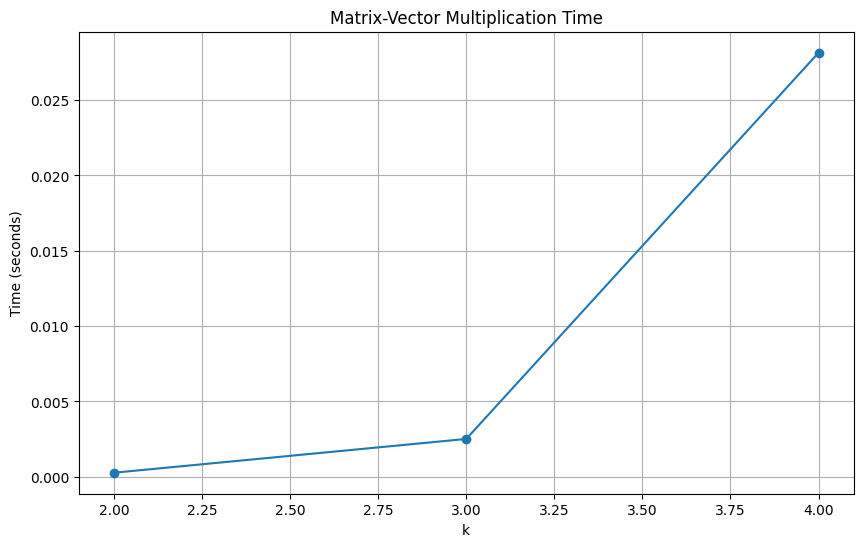

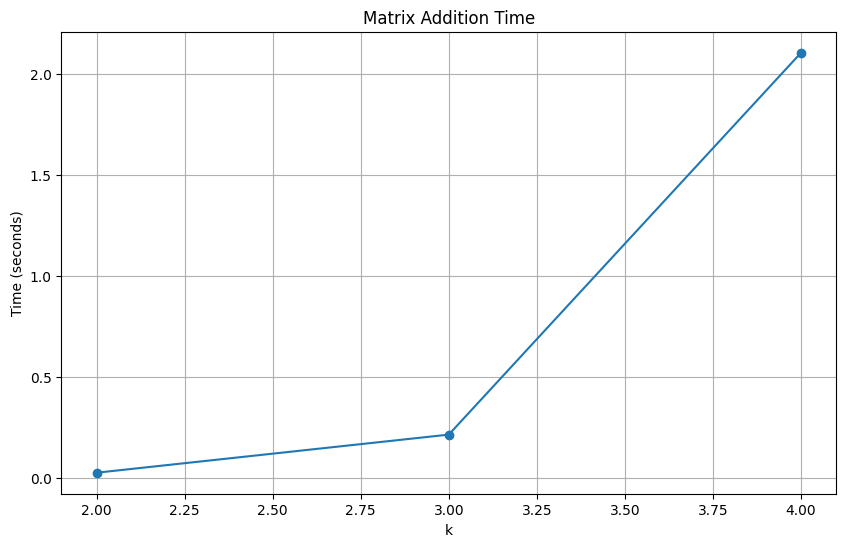

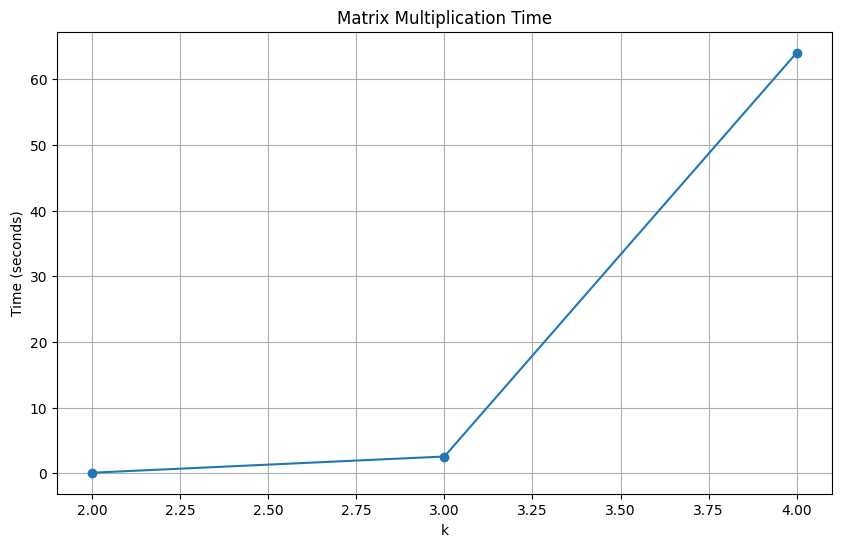

In [13]:
import matplotlib.pyplot as plt

# Plotting matrix-vector multiplication time
plt.figure(figsize=(10, 6))
plt.plot(df['k'], df['matrix x vector time'], marker='o')
plt.title('Matrix-Vector Multiplication Time')
plt.xlabel('k')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()



# Plotting matrix addition time
plt.figure(figsize=(10, 6))
plt.plot(df['k'], df['matrix + matrix time'], marker='o')
plt.title('Matrix Addition Time')
plt.xlabel('k')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()



# Plotting matrix multiplication time
plt.figure(figsize=(10, 6))
plt.plot(df['k'], df['matrix x matrix time'], marker='o')
plt.title('Matrix Multiplication Time')
plt.xlabel('k')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()



# Oszacowanie złożoności obliczeniowej dla poszczególnych operacji

Dopasowane parametry: a = 0.0000, b = 8.3720


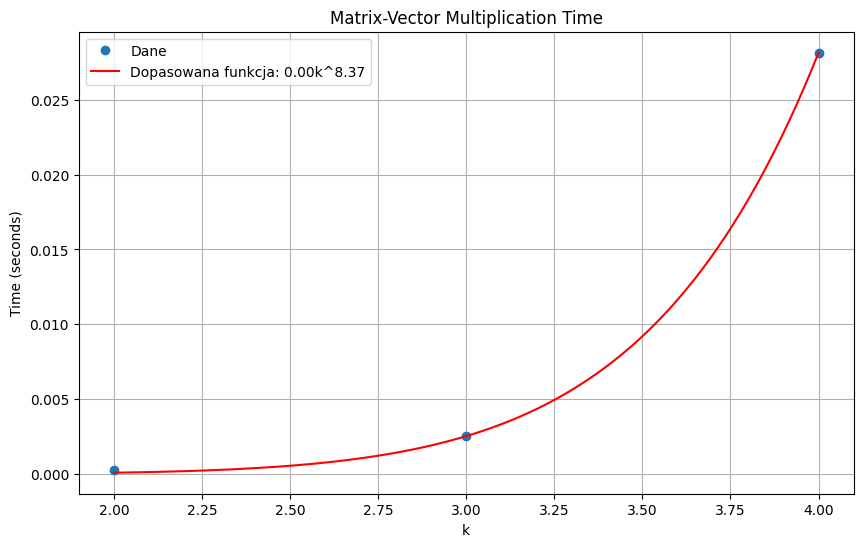

Dopasowane parametry: a = 0.0000, b = 7.9172


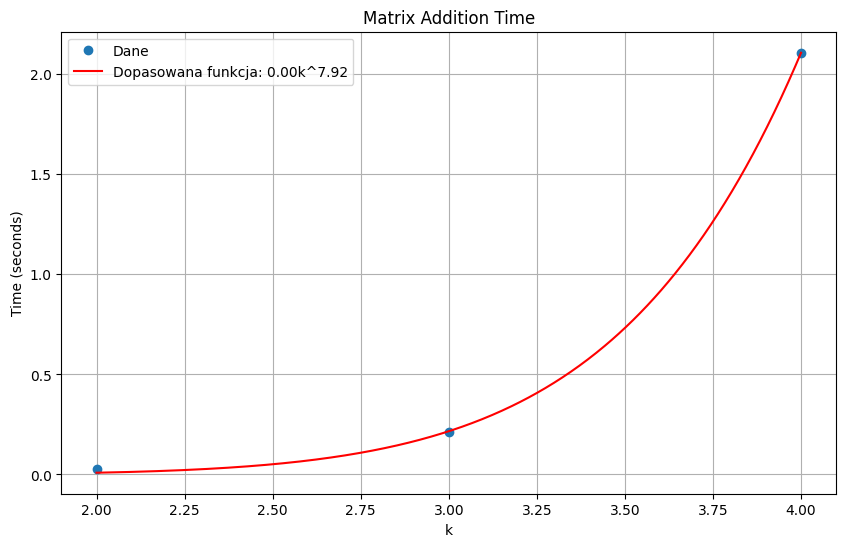

Dopasowane parametry: a = 0.0000, b = 11.1935


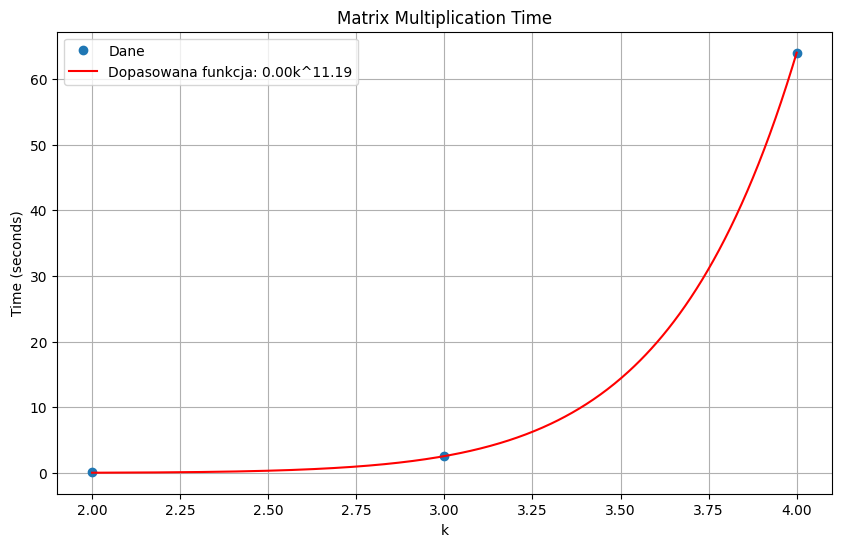

In [14]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definicja modelu a * N^b
def model(k, a, b):
    return a * k**b

# Funkcja do dopasowania modelu i rysowania wykresu
def plot_with_fit(k_data, time_data, title, xlabel, ylabel):
    # Dopasowanie funkcji do danych
    params, _ = curve_fit(model, k_data, time_data)
    a, b = params
    print(f'Dopasowane parametry: a = {a:.4f}, b = {b:.4f}')

    # Generowanie gęstszych punktów do rysowania ciągłej krzywej dopasowania
    k_fit = np.linspace(min(k_data), max(k_data), 500)  # Gęstsze punkty w zakresie danych
    time_fit = model(k_fit, *params)  # Obliczenie wartości dopasowanej funkcji dla tych punktów

    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))
    plt.plot(k_data, time_data, 'o', label='Dane', markersize=6)  # Dyskretne punkty danych
    plt.plot(k_fit, time_fit, 'r-', label=f'Dopasowana funkcja: {a:.2f}k^{b:.2f}')  # Ciągła linia dopasowania
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting matrix-vector multiplication time
plot_with_fit(df['k'], df['matrix x vector time'],
              'Matrix-Vector Multiplication Time', 'k', 'Time (seconds)')

# Plotting matrix addition time
plot_with_fit(df['k'], df['matrix + matrix time'],
              'Matrix Addition Time', 'k', 'Time (seconds)')

# Plotting matrix multiplication time
plot_with_fit(df['k'], df['matrix x matrix time'],
              'Matrix Multiplication Time', 'k', 'Time (seconds)')


